In [ ]:
import ast
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from PIL import Image, ImageDraw
from torchvision.transforms import functional as TF


In [23]:
def hardware_check():

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU is available!")
        print(f"  -> GPU - {torch.cuda.get_device_name()}")
        print(f"  -> Total Memory: {torch.cuda.get_device_properties().total_memory / 1024**3:.2f} GB")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU.")
        print("\nCPU Information:")

        cpu_model = os.popen("cat /proc/cpuinfo | grep \"model name\" | uniq").read().strip()
        print(f"CPU Model: {cpu_model}")
        print(f"Number of CPU cores: {os.cpu_count()}")

    return device

device = hardware_check()
print(f"\nUsing {device} for computation")

GPU is available!
  -> GPU - NVIDIA RTX 4000 Ada Generation
  -> Total Memory: 19.57 GB

Using cuda for computation


In [24]:
# Percorso locale al dataset
dataset_path = 'CCPD2019' 

if os.path.exists(dataset_path):
    print("Dataset trovato in locale!")
else:
    print(f"Dataset non trovato al percorso: {dataset_path}")


Dataset trovato in locale!


In [ ]:
# Trasformazione per il dataset CCPD (in formato YOLO)

class YoloCCPDTransformCentered:
    def __init__(self, dataset_path, size=(640, 640)):

        self.dataset_path = dataset_path
        self.size = size  # (H, W)

    def __call__(self, row):

        image_path = os.path.join(self.dataset_path, row['image_path'])
        if not os.path.isfile(image_path):
            return None

        image = Image.open(image_path).convert("RGB")
        orig_w, orig_h = image.size

        bbox = row['bbox']
        if isinstance(bbox, str):
            bbox = ast.literal_eval(bbox)

        x_min, y_min, x_max, y_max = bbox
        box_w = x_max - x_min
        box_h = y_max - y_min
        box_cx = (x_min + x_max) / 2
        box_cy = (y_min + y_max) / 2

        # Ritaglio quadrato massimo possibile centrato sulla targa
        dist_x = min(box_cx, orig_w - box_cx)
        dist_y = min(box_cy, orig_h - box_cy)
        half_side = min(dist_x, dist_y)

        crop_xmin = int(box_cx - half_side)
        crop_ymin = int(box_cy - half_side)
        crop_xmax = int(box_cx + half_side)
        crop_ymax = int(box_cy + half_side)

        crop = image.crop((crop_xmin, crop_ymin, crop_xmax, crop_ymax))

        # Aggiornamento bbox relativa al crop
        new_x_min = x_min - crop_xmin
        new_y_min = y_min - crop_ymin
        new_x_max = x_max - crop_xmin
        new_y_max = y_max - crop_ymin

        crop_tensor = TF.to_tensor(crop)
        crop_h, crop_w = crop_tensor.shape[1:]
        resized = TF.resize(crop_tensor, self.size, interpolation=Image.BILINEAR)

        scale_x = self.size[1] / crop_w
        scale_y = self.size[0] / crop_h

        x_min_resized = new_x_min * scale_x
        y_min_resized = new_y_min * scale_y
        x_max_resized = new_x_max * scale_x
        y_max_resized = new_y_max * scale_y

        # Normalizzazione bbox (formato YOLO)
        x_center = (x_min_resized + x_max_resized) / 2 / self.size[1]
        y_center = (y_min_resized + y_max_resized) / 2 / self.size[0]
        width = (x_max_resized - x_min_resized) / self.size[1]
        height = (y_max_resized - y_min_resized) / self.size[0]

        # Clipping di sicurezza
        x_center = min(max(x_center, 0.0), 1.0)
        y_center = min(max(y_center, 0.0), 1.0)
        width = min(max(width, 0.0), 1.0)
        height = min(max(height, 0.0), 1.0)
        

        label = [0, x_center, y_center, width, height]

        return {
            'image': resized,
            'label': torch.tensor(label, dtype=torch.float32)
        }


In [ ]:
# Funzione per visualizzare coppie di immagini originali e trasformate con bounding box

def plot_ccpd_pair(df, dataset_path, transformer=None, title='Sample'):

    for _, row in df.iterrows():
        image_path = os.path.join(dataset_path, row['image_path'])
        if not os.path.isfile(image_path):
            continue 

        image = Image.open(image_path).convert("RGB")
        draw_orig = ImageDraw.Draw(image)

        bbox = row['bbox']
        if isinstance(bbox, str):
            bbox = ast.literal_eval(bbox)

        draw_orig.rectangle(bbox, outline='red', width=3)

        if transformer:
            sample = transformer(row)
            if sample is None:
                continue

            transformed_img = sample['image'].permute(1, 2, 0).numpy()
            label = sample['label'].tolist()
            _, x_center, y_center, width, height = label
            H, W = sample['image'].shape[1:]

            x_min = int((x_center - width / 2) * W)
            y_min = int((y_center - height / 2) * H)
            x_max = int((x_center + width / 2) * W)
            y_max = int((y_center + height / 2) * H)

            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(image)
            axes[0].set_title("Original + BBox")

            axes[1].imshow(transformed_img)
            axes[1].add_patch(plt.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                edgecolor='red', facecolor='none', linewidth=2
            ))
            axes[1].set_title("Transformed + BBox")

        else:
            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(image)
            ax.set_title("Original")

        if title:
            fig.suptitle(title, weight='bold')

        plt.tight_layout()
        plt.show()
        break 


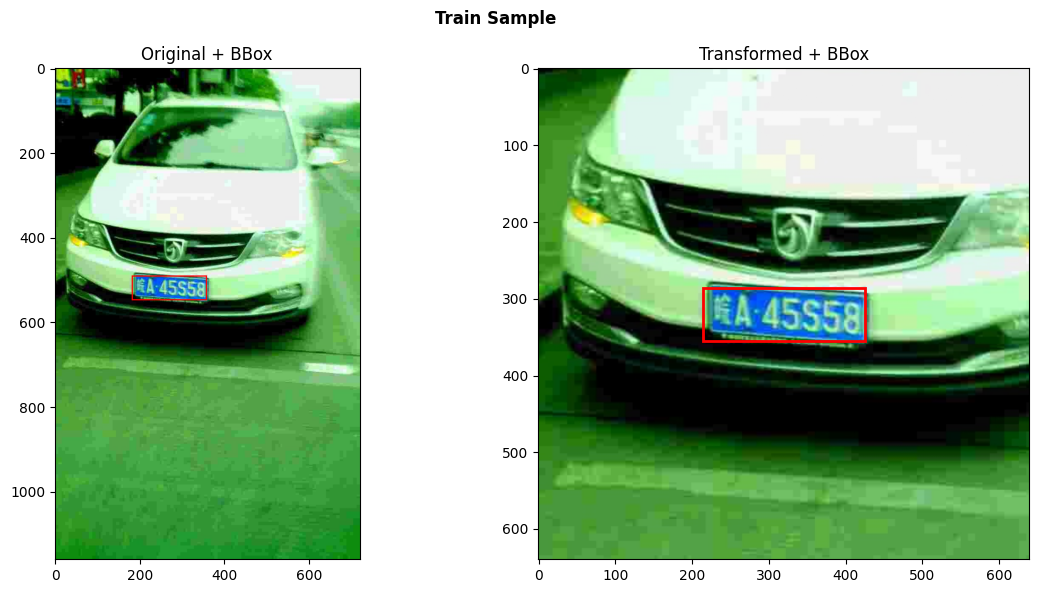

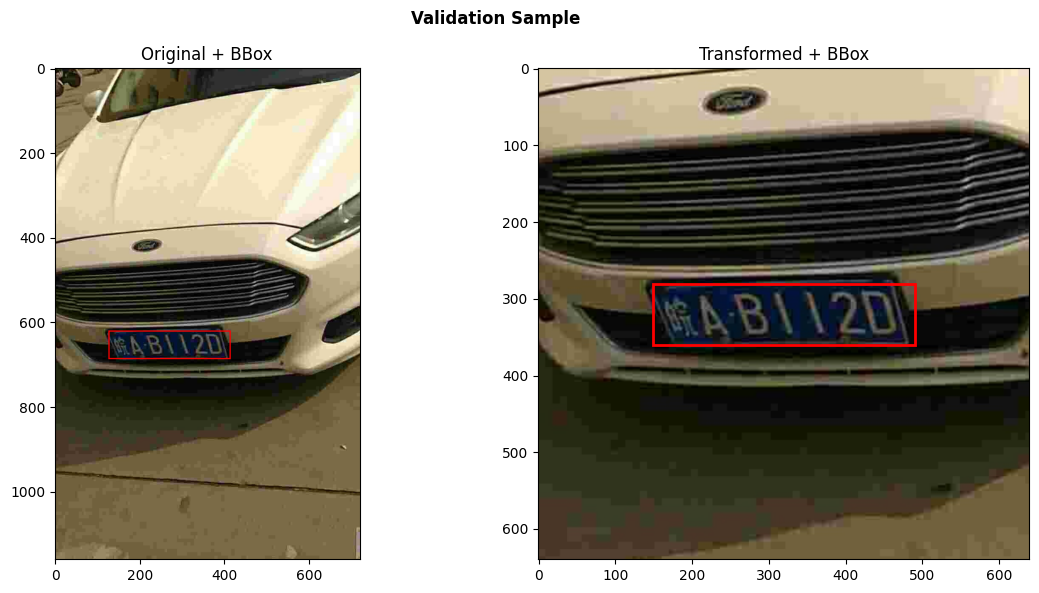

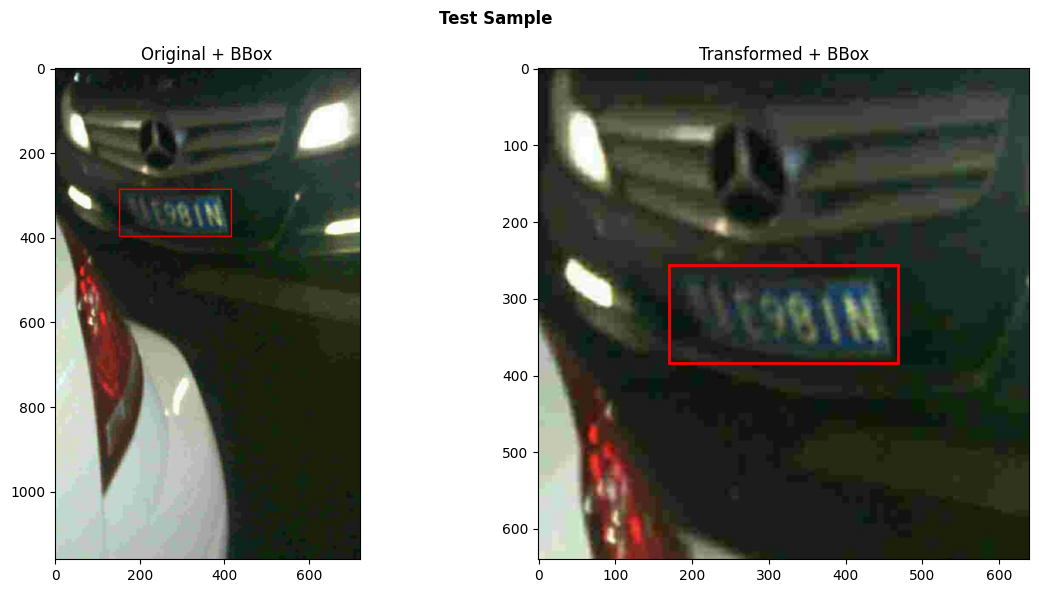

In [ ]:
transformer = YoloCCPDTransformCentered(dataset_path=dataset_path)
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

# Esempio dal TRAIN
plot_ccpd_pair(train_df, dataset_path, transformer=transformer, title="Train Sample")

# Esempio dal VAL
plot_ccpd_pair(val_df, dataset_path, transformer=transformer, title="Validation Sample")

# Esempio dal TEST
plot_ccpd_pair(test_df, dataset_path, transformer=transformer, title="Test Sample")


In [30]:
import os
import pandas as pd
from tqdm import tqdm
import torch
from torchvision import transforms

def create_yolo_format(dataset_path, csv_paths, transformer, max_samples=None):

    yolo_root = os.path.join(dataset_path, 'YOLO_format')
    os.makedirs(yolo_root, exist_ok=True)

    for split, csv_file in csv_paths.items():
        df = pd.read_csv(csv_file)

        split_img_dir = os.path.join(yolo_root, 'images', split)
        split_label_dir = os.path.join(yolo_root, 'labels', split)
        os.makedirs(split_img_dir, exist_ok=True)
        os.makedirs(split_label_dir, exist_ok=True)

        if max_samples and split in max_samples:
            df = df.iloc[:max_samples[split]]

        for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split}"):
            img_name = os.path.basename(row['image_path'])
            img_save_path = os.path.join(split_img_dir, img_name)
            label_filename = os.path.splitext(img_name)[0] + '.txt'
            label_save_path = os.path.join(split_label_dir, label_filename)

            if os.path.exists(img_save_path) and os.path.exists(label_save_path):
                continue

            sample = transformer(row)
            if sample is None:
                continue

            img_pil = transforms.ToPILImage()(sample['image'].cpu())
            img_pil.save(img_save_path)

            labels = sample['label'].cpu().numpy()

            with open(label_save_path, 'w') as f:
                if labels.ndim == 1:
                    labels = labels.reshape(1, -1)

                for obj in labels:
                    class_id, x_center, y_center, width, height = obj
                    f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print("Creazione dataset in formato YOLOv5 completata.")

csv_paths = {'train': 'train.csv', 'val': 'val.csv', 'test': 'test.csv'}
create_yolo_format(dataset_path, csv_paths, transformer)


Processing test: 100%|██████████| 141982/141982 [00:07<00:00, 19108.67it/s]

Creazione dataset in formato YOLOv5 completata.


In [31]:
# Creazione dei dataset splittati per il test (in formato YOLO)
# csv_paths = {'ccpd_blur': './csv_splits/ccpd_blur.csv', 'ccpd_db': './csv_splits/ccpd_db.csv', 'ccpd_fn': './csv_splits/ccpd_fn.csv','ccpd_rotate': './csv_splits/ccpd_rotate.csv', 'ccpd_tilt': './csv_splits/ccpd_tilt.csv', 'ccpd_weather': './csv_splits/ccpd_weather.csv','ccpd_challenge':'./csv_splits/ccpd_challenge.csv'}
# create_yolo_format(dataset_path, csv_paths, transformer)

In [32]:
def check_and_visualize_yolo_dataset(yolo_root):

    splits = ['train', 'val', 'test']

    for split in splits:
        img_dir = os.path.join(yolo_root, 'images', split)
        label_dir = os.path.join(yolo_root, 'labels', split)

        img_files = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
        total_imgs = len(img_files)
        valid_labels = 0
        example_img = None
        example_bbox = None

        for img_path in img_files:
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            label_path = os.path.join(label_dir, base_name + '.txt')

            if os.path.isfile(label_path):
                valid_labels += 1

                if example_img is None:
                    example_img = Image.open(img_path).convert('RGB')
                    with open(label_path, 'r') as f:
                        line = f.readline().strip()
                        if line:
                            parts = line.split()
                            x_center, y_center, width, height = map(float, parts[1:5])
                            w, h = example_img.size
                            x_min = int((x_center - width / 2) * w)
                            y_min = int((y_center - height / 2) * h)
                            x_max = int((x_center + width / 2) * w)
                            y_max = int((y_center + height / 2) * h)
                            example_bbox = [x_min, y_min, x_max, y_max]

        print(f"Split: {split}")
        print(f"Totale immagini: {total_imgs}")
        print(f"Immagini con label valide: {valid_labels}\n")

        if example_img is not None and example_bbox is not None:
            draw = ImageDraw.Draw(example_img)
            draw.rectangle(example_bbox, outline='red', width=3)

            plt.figure(figsize=(6,6))
            plt.imshow(example_img)
            plt.title(f"Esempio da {split} con bounding box")
            plt.axis('off')
            plt.show()
        else:
            print(f"Nessun esempio valido trovato per split {split}\n")


Split: train
Totale immagini: 100000
Immagini con label valide: 100000



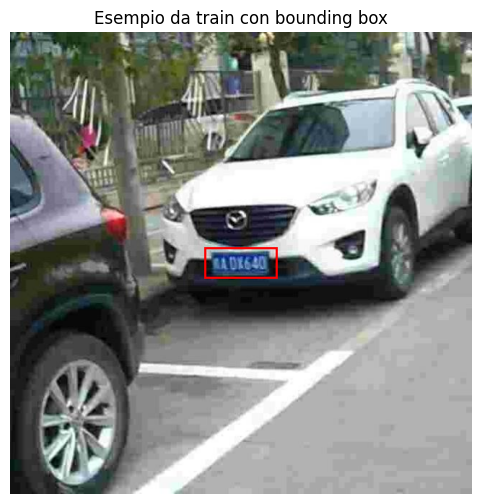

Split: val
Totale immagini: 99996
Immagini con label valide: 99996



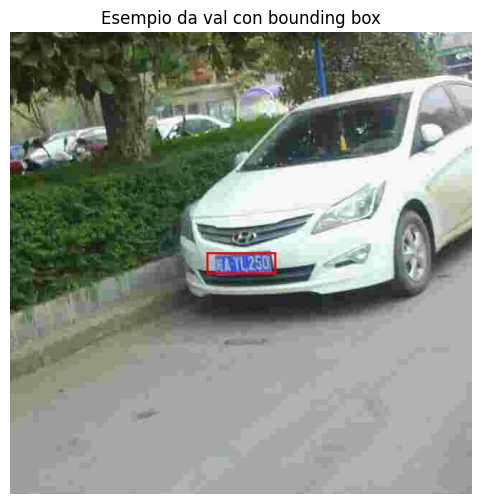

Split: test
Totale immagini: 100579
Immagini con label valide: 100579



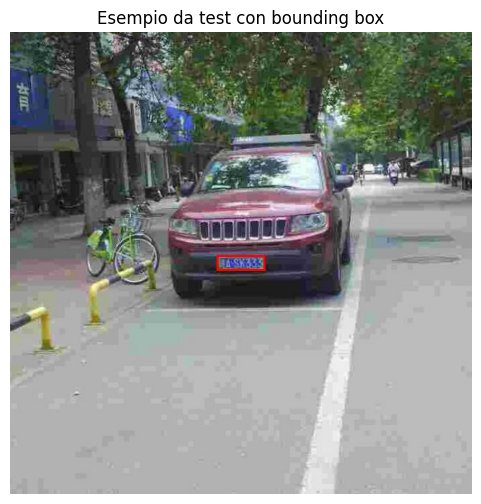

In [33]:
yolo_root = os.path.join(dataset_path, 'YOLO_format')
check_and_visualize_yolo_dataset(yolo_root)

In [ ]:
# È necessario a questo punto clonare la repository YOLOv5 per poter procedere con l'addestramento.

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs


Risultati per 00224137931034-90_87-351&564_451&606-440&599_362&600_359&572_437&571-0_0_3_21_30_28_24-88-5.jpg:


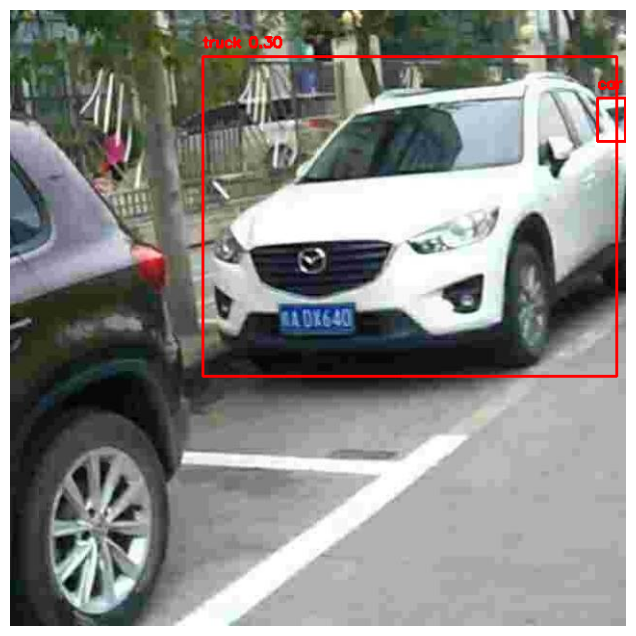

Risultati per 00227490421455-90_88-341&443_436&482-437&479_338&486_335&452_434&445-0_0_9_33_33_29_28-128-12.jpg:


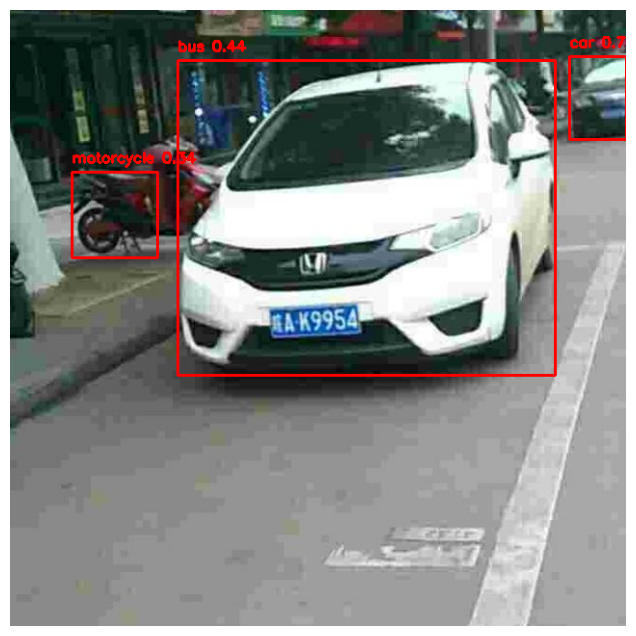

In [39]:
%matplotlib inline

import sys
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision import transforms

# Configurazione percorsi
repo_dir = 'yolov5' 
weights_path = os.path.join(repo_dir, 'yolov5s.pt')  
dataset_YOLO = 'CCPD2019/YOLO_format/images/train'


sys.path.insert(0, repo_dir)

# Importa modello
from models.common import DetectMultiBackend

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carica modello
model = DetectMultiBackend(weights_path, device=device, dnn=False)

# Funzione inferenza e visualizzazione con NMS corretta
def infer_and_plot(model, img_path, device, input_size=(640, 640), conf_thres=0.25, iou_thres=0.45):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
    ])

    img = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Inference (output raw)
    pred = model(input_tensor)

    # Importa la funzione di non max suppression dalla repo yolov5
    from utils.general import non_max_suppression

    detections = non_max_suppression(pred, conf_thres, iou_thres)[0]

    print(f"Risultati per {os.path.basename(img_path)}:")
    if detections is None or len(detections) == 0:
        print("Nessuna predizione trovata.")
        return

    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    for *xyxy, conf, cls in detections.cpu().numpy():
        x1, y1, x2, y2 = map(int, xyxy)
        label = f"{model.names[int(cls)]} {conf:.2f}"
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_cv, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(img_cv)
    plt.axis('off')
    plt.show()

# Inferenza su prime 2 immagini
image_files = sorted(os.listdir(dataset_YOLO))[:2]

for img_file in image_files:
    img_path = os.path.join(dataset_YOLO, img_file)
    infer_and_plot(model, img_path, device)


In [ ]:
# Si riporta a titolo di esempio il comando utilizzato per lanciare l'addestramento con YOLOv5
!cd yolov5 && python train.py \
  --img 640 \
  --batch 50 \
  --epochs 10 \
  --data data.yaml \
  --weights yolov5s.pt \
  --optimizer Adam \
  --hyp data/hyps/hyp_ccpd.yaml \
  --name yolov5_ccpd_adam


In [ ]:
# Si riporta a titolo di esempio il comando utilizzato per la validazione del modello addestrato
!cd yolov5 && python yolov5/val.py --weights best_yolo_weights.pt --data data_test.yaml --task test --batch 5 --workers 0